# Training a subset of parameters

Sometimes when training a neural network it is useful to hold some parameters of your network fixed while updating others. This is commonly referred to as "non-trainable variables" or "layer freezing".

In typical neural network training, parameters are updated by computing gradients and computing an update via an optimizer such as SGD or ADAM. Updates are then applied to parameters and the process repeats until you have converged.

As such to implement "layer freezing" or "non-trainable variables" in JAX, we simply need to not compute and apply updates for certain parameters of our network.

In JAX computing gradients and applying updates to parameters are fully in your control as a user. JAX's autodiff mechanics allow you to compute gradients wrt any positional argument to a function.

In Haiku (and other NN libraries) it is typical to pass your parameters as a single positional argument to your function (e.g. `grads = jax.grad(loss_fn)(params, ...)`).

To support taking gradients wrt a subset of parameters, we need to allow users to split their parameters into two positional arguments, such that they can compute gradients wrt a subset of their parameters (e.g. `trainable_params_grads = jax.grad(loss_fn)(trainable_params, non_trainable_params, ...)`).

Haiku ships with some utilities that make it easier to manipulate the parameters dictionary in order to split into these trainable/non-trainable sets as well as to recombine your parameters into a single dictionary.

We will walk through how to do this with a simple MLP and teach it the identity function.

In [ ]:
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np

The forward pass of our network is a standard MLP. We want to adjust the parameters of this MLP such that it computes the identity. That is `forward([[1.0], [2.0], [3.0]) == [1, 2, 3]`. We will do this for a maximum of 10 numbers.

Our network starts randomly initialised so the results initially do not make much sense:

In [ ]:
num_classes = 10

def f(x):
  return hk.nets.MLP([300, 100, num_classes])(x)

f = hk.transform(f)

def test(params, num_classes=num_classes):
  x = np.arange(num_classes).reshape([num_classes, 1]).astype(np.float32)
  y = jnp.argmax(f.apply(params, None, x), axis=-1)
  for x, y in zip(x, y):
    print(x, "->", y)

rng = jax.random.PRNGKey(42)
x = np.zeros([num_classes, 1])
params = f.init(rng, x)

print("before training")
test(params)

/tmp/haiku-docs-env/lib/python3.8/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


before training
[0.] -> 0
[1.] -> 3
[2.] -> 3
[3.] -> 3
[4.] -> 3
[5.] -> 3
[6.] -> 3
[7.] -> 3
[8.] -> 3
[9.] -> 3


It is useful to visualise our paramerters so we can compare to their final state:

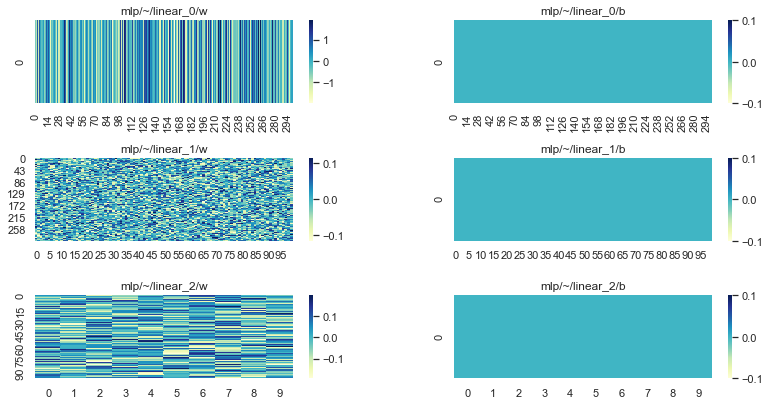

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

def plot_params(params):
  fig, axs = plt.subplots(ncols=2, nrows=3)
  fig.tight_layout()
  fig.set_figwidth(12)
  fig.set_figheight(6)
  for row, module in enumerate(sorted(params)):
    ax = axs[row][0]
    sns.heatmap(params[module]["w"], cmap="YlGnBu", ax=ax)
    ax.title.set_text(f"{module}/w")

    ax = axs[row][1]
    b = np.expand_dims(params[module]["b"], axis=0)
    sns.heatmap(b, cmap="YlGnBu", ax=ax)
    ax.title.set_text(f"{module}/b")

plot_params(params)

To train our network we'll create some simple synthetic batches of data:

In [ ]:
def dataset(*, batch_size, num_records):
  for _ in range(num_records):
    y = np.arange(num_classes)
    y = np.random.permutation(y)[:batch_size]
    x = y.reshape([batch_size, 1]).astype(np.float32)
    yield x, y

for x, y in dataset(batch_size=4, num_records=5):
  print("x :=", x.tolist(), "y :=", y)

x := [[0.0], [8.0], [7.0], [1.0]] y := [0 8 7 1]
x := [[6.0], [7.0], [0.0], [9.0]] y := [6 7 0 9]
x := [[4.0], [0.0], [9.0], [6.0]] y := [4 0 9 6]
x := [[0.0], [4.0], [6.0], [5.0]] y := [0 4 6 5]
x := [[4.0], [3.0], [0.0], [5.0]] y := [4 3 0 5]


Now for the interesting part. Lets pretend that we only want to update the parameters of the first and last layer of our MLP.

The simplest and most efficient way to do this is to partition our parameters into two groups, "trainable" and "non trainable". Haiku provides a convenience function for doing this in `hk.data_structures.partition(..)`:

In [ ]:
# Partition our params into trainable and non trainable explicitly.
trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda m, n, p: m != "mlp/~/linear_1", params)

print("trainable:", list(trainable_params))
print("non_trainable:", list(non_trainable_params))

trainable: ['mlp/~/linear_0', 'mlp/~/linear_2']
non_trainable: ['mlp/~/linear_1']


The reason we split our parameters is that this allows us to pass them to our loss function as separate positional arguments.

In JAX gradients are taken with respect to positional arguments. By splitting our parameters into two groups we can take gradients with respect to just one of the positional arguments. We can then use those gradients to update a subset of our parameters.

The last piece of the puzzle is that we need to combine our "trainable" and "non trainable" parameters together before calling our apply function. Again Haiku provides `hk.data_structures.merge(..)` to make this easy:

In [ ]:
def loss_fn(trainable_params, non_trainable_params, images, labels):
  # NOTE: We need to combine trainable and non trainable before calling apply.
  params = hk.data_structures.merge(trainable_params, non_trainable_params)

  # NOTE: From here on this is a standard softmax cross entropy loss.
  logits = f.apply(params, None, images)
  labels = jax.nn.one_hot(labels, logits.shape[-1])
  return -jnp.sum(labels * jax.nn.log_softmax(logits)) / labels.shape[0]

def sgd_step(params, grads, *, lr):
  return jax.tree_util.tree_map(lambda p, g: p - g * lr, params, grads)

def train_step(trainable_params, non_trainable_params, x, y):
  # NOTE: We will only compute gradients wrt `trainable_params`.
  trainable_params_grads = jax.grad(loss_fn)(trainable_params,
                                             non_trainable_params, x, y)

  # NOTE: We are only updating `trainable_params`.
  trainable_params = sgd_step(trainable_params, trainable_params_grads, lr=0.1)
  return trainable_params

train_step = jax.jit(train_step)

for x, y in dataset(batch_size=num_classes, num_records=10000):
  # NOTE: In our training loop only our trainable parameters are updated.
  trainable_params = train_step(trainable_params, non_trainable_params, x, y)

We can see that even though we only trained a subset of our parameters, our NN is able to learn this simple function:

In [ ]:
# Merge params again for inference.
params = hk.data_structures.merge(trainable_params, non_trainable_params)

print("after training")
test(params)

after training
[0.] -> 0
[1.] -> 1
[2.] -> 2
[3.] -> 3
[4.] -> 4
[5.] -> 5
[6.] -> 6
[7.] -> 7
[8.] -> 8
[9.] -> 9


Of course it is not smart enough to generalize to out of distribution inputs:

In [ ]:
test(params, num_classes=num_classes+10)

[0.] -> 0
[1.] -> 1
[2.] -> 2
[3.] -> 3
[4.] -> 4
[5.] -> 5
[6.] -> 6
[7.] -> 7
[8.] -> 8
[9.] -> 9
[10.] -> 9
[11.] -> 9
[12.] -> 9
[13.] -> 9
[14.] -> 9
[15.] -> 9
[16.] -> 9
[17.] -> 9
[18.] -> 9
[19.] -> 9


Looking at our parameters we can see that `linear_1` is still in its initial state (randomly initialised weight matrix and zero initialized bias):

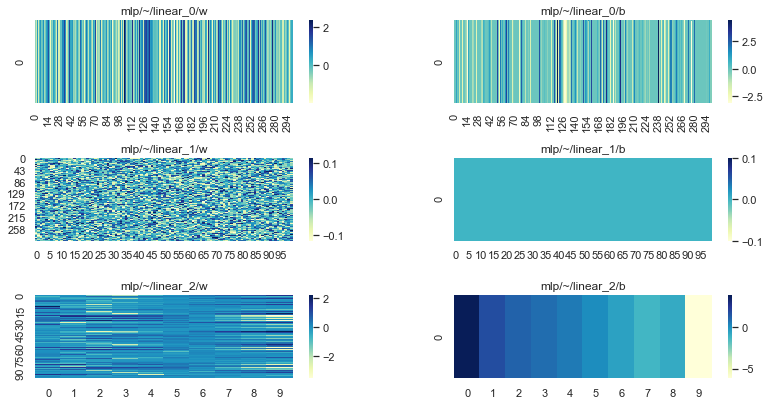

In [ ]:
plot_params(params)

## Freezing layers with Optax

Alternatively, [Optax](https://github.com/deepmind/optax) users can fix parameters using [`optax.multi_transform`](https://optax.readthedocs.io/en/latest/api.html#optax.multi_transform). Users can read more [here](https://github.com/google/flax/discussions/1453).

